# MODELING

## Objectives:

* Build a classifier to predict whether a customer will ("soon") stop doing business with SyriaTel.
* Determine which modeling method will bring about the best performance
* What are the top 5 most effective features effective on customer churn decision?
* Are there any predictable patterns?

## IMPORT DATA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

#Sampling
from collections import Counter
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Logistic Regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# Naive Bayes
from scipy import stats

# Decision Trees
from math import log #to calculate entropy
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree

# Regression with CART Trees
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Random Forest
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# GridSearch
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

# Gradient Boosting
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# XGBoost
import xgboost as xgb # xgb.XGBClassifier()

# SVM
from sklearn import svm
from sklearn.svm import SVC
import statsmodels as sm


# Pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline


import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('CSV_Files/customer_churn_data_cleaned.csv').drop('Unnamed: 0', axis=1)

print('DataFrame Shape:', df.shape)
df.head()

DataFrame Shape: (3333, 40)


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,night_call_length_per_call,intl_call_length_per_call,day_charge_per_min,eve_charge_per_min,night_charge_per_min,intl_charge_per_min,day_charge_percentage,eve_charge_percentage,night_charge_percentage,intl_charge_percentage
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,...,2.689,3.333,0.17,0.085,0.045,0.27,0.593,0.221,0.145,0.036
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,...,2.470,4.567,0.17,0.085,0.045,0.27,0.466,0.282,0.194,0.063
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,...,1.563,2.440,0.17,0.085,0.045,0.27,0.667,0.166,0.118,0.053
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,...,2.212,0.943,0.17,0.085,0.045,0.27,0.760,0.079,0.132,0.027
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,...,1.545,3.367,0.17,0.085,0.045,0.27,0.545,0.242,0.162,0.052


In [3]:
df['churn'].value_counts()

0    2850
1     483
Name: churn, dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   state                         3333 non-null   object 
 1   account_length                3333 non-null   int64  
 2   area_code                     3333 non-null   int64  
 3   international_plan            3333 non-null   int64  
 4   voice_mail_plan               3333 non-null   int64  
 5   number_vmail_messages         3333 non-null   int64  
 6   total_day_minutes             3333 non-null   float64
 7   total_day_calls               3333 non-null   int64  
 8   total_day_charge              3333 non-null   float64
 9   total_eve_minutes             3333 non-null   float64
 10  total_eve_calls               3333 non-null   int64  
 11  total_eve_charge              3333 non-null   float64
 12  total_night_minutes           3333 non-null   float64
 13  tot

## CLASSIFICATION MODEL FUNCTIONS

### Prediction Function

In [5]:
def model_predictions(model, X_train, X_test, y_train, y_test):
    """
    Input: Training and test sets of predictors 
    Output: The accuracy_score of the given sets for each class..
    """
    
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    
    train_residuals = np.abs(y_train - y_hat_train)
    print('Training Values','\n', pd.Series(train_residuals).value_counts())
    print('------------------------------------')
    print('Training Accuracy','\n', pd.Series(train_residuals).value_counts(normalize=True))
    print('\n\n')
    
    test_residuals = np.abs(y_test - y_hat_test)
    print('Testing Values: ','\n', pd.Series(test_residuals).value_counts())
    print('------------------------------------')
    print('Testing Accuracy: ','\n', pd.Series(test_residuals).value_counts(normalize=True))

### Confusion Matrix Function

In [6]:
def confusion_matrix(model, X_test, y_test):

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()

    y_pred = model.predict(X_test)

    print('------------------------------------')
    # print('Accuracy Score:')
    # print(accuracy_score(y_test, y_pred)
    print("Testing Accuracy for Our Classifier: {:.4}%".format(accuracy_score(y_test, y_pred) * 100))

    
    print('------------------------------------')
    print('Classification Matrix:')
    print(classification_report(y_test, y_pred))

### ROC Curve Function

In [7]:
def plot_roc(model, X_train, X_test, y_train, y_test):

    """
    Input: Model, Train and Test data.
    Output: Train and Test AUC, Roc Curve for Train and Test sets.
    This function works for classification models with decision_function attribute.
    """
    y_train_score = model.decision_function(X_train)
    y_test_score = model.decision_function(X_test)
    
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)
    
    print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    print('------------------------------------')
    
    plt.figure(figsize=(10, 8))
    lw = 2
    
    plt.plot(train_fpr, train_tpr, color='blue',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='darkorange',
             lw=lw, label='Test ROC curve')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [8]:
def plot_roc_pp(model, X_train, X_test, y_train, y_test):

    """
    Input: Model, Train and Test data.
    Output: Train and Test AUC, Roc Curve for Train and Test sets.
    This function works for classification models with predict_proba attribute.
    """
    y_train_score = model.predict_proba(X_train)
    y_test_score = model.predict_proba(X_test)
    
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_score [:,1])
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score [:,1])
    
    print('Train AUC: {}'.format(auc(train_fpr, train_tpr)))
    print('Test AUC: {}'.format(auc(test_fpr, test_tpr)))
    print('------------------------------------')
    
    plt.figure(figsize=(10, 8))
    lw = 2
    
    plt.plot(train_fpr, train_tpr, color='blue',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='darkorange',
             lw=lw, label='Test ROC curve')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

### Model Control Function

In [9]:
def model_control(model, X_train, X_test, y_train, y_test):

    """
    This function includes all the functions we created above.
    ROC Curve has decision_function attribute.
    """

    model.fit(X_train, y_train)
    print('Train Score:', model.score(X_train, y_train))
    print('Test Score:', model.score(X_test, y_test))
    print('------------------------------------')

    model_predictions(model, X_train, X_test, y_train, y_test)
    confusion_matrix(model, X_test, y_test)
    plot_roc(model, X_train, X_test, y_train, y_test)

In [10]:
def model_control_pp(model, X_train, X_test, y_train, y_test):

    """
    This function includes all the functions we created above.
    Roc Curve has predict_proba attribute.
    """
    
    model.fit(X_train, y_train)
    print('Train Score:', model.score(X_train, y_train))
    print('Test Score:', model.score(X_test, y_test))
    print('------------------------------------')
    
    model_predictions(model, X_train, X_test, y_train, y_test)
    confusion_matrix(model, X_test, y_test)
    plot_roc_pp(model, X_train, X_test, y_train, y_test)

### Feature Importance Plot Function

In [11]:
def plot_feature_importances(model, X, X_train):
    n_features = X_train.shape[1]
    sns.set_style('darkgrid')
    plt.figure(figsize=(8, 11))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values, fontsize=13) 
    plt.xlabel('Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title('Feature Importance', fontsize=20)

## MODELS

***Define our X and y values.***

In [13]:
y = df['churn']
X = df.drop(['churn', 'state', 'area_code'], axis=1)

### LOGISTIG REGRESSION

#### Model

In [14]:
    """
    Train/test split with 75/25 rate and set random_state to 123. 
    We will apply train/test split for each classifier model since the data learn from previous models.
    """

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

In [16]:
    """
    We will use StandardScaler to scale our training data.
    We will use Recursive Feature Elimination(RFE) to select the top 10 columns to fit out model.
    Set random_state to 123 for our Logistic Regression model and determine parameters. 
    """

scaler = StandardScaler()
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10)
model = LogisticRegression(fit_intercept=False, 
                           C=10e16,  
                           solver='liblinear',
                           class_weight='balanced', 
                           max_iter=10000, 
                           random_state=123)                        


pipeline_lr = Pipeline(steps=[('s', rfe), 
                              ('ss', scaler), 
                              ('m', model)])

# Fit the model

pipeline_lr.fit(X_train, y_train)

print('Train Score:', pipeline_lr.score(X_train, y_train))
print('Test Score:', pipeline_lr.score(X_test, y_test))

Train Score: 0.725890356142457
Test Score: 0.7673860911270983


As we can see our train and test scores are relatively high for base model. Let's dig deeper in our predictions before we make adjustments in our model to see how it can me improved.

#### Predictions

In [17]:
# We will use our model_predictions function to check the accuracy of predicting each class for both our train and test datasets.
model_predictions(pipeline_lr, X_train, X_test, y_train, y_test)

Training Values 
 0    1814
1     685
Name: churn, dtype: int64
------------------------------------
Training Accuracy 
 0    0.72589
1    0.27411
Name: churn, dtype: float64



Testing Values:  
 0    640
1    194
Name: churn, dtype: int64
------------------------------------
Testing Accuracy:  
 0    0.767386
1    0.232614
Name: churn, dtype: float64


Our model has relatively high accuracy when predicting 0s in our target and rather low accuracy when predicting 1s for our base model. Balanced class weight parameter is not good enough for {'0': 0.86, '1': 0.14} class imbalance.

#### Confusion Matrix

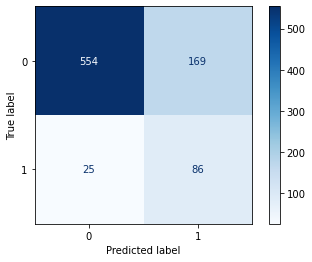

------------------------------------
Testing Accuracy for Decision Tree Classifier: 76.74%
------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       723
           1       0.34      0.77      0.47       111

    accuracy                           0.77       834
   macro avg       0.65      0.77      0.66       834
weighted avg       0.87      0.77      0.80       834



In [18]:
confusion_matrix(pipeline_lr, X_test, y_test)

For our classification models, we will focus on precision. Our base model has 723:111 class imbalance. 0.96 precision when predicting 0s and only 0.34 precision when predicting 1s. Our recall numbers are relatively more balanced and f-1 score is 0.47 when predicting 1s. 

#### ROC Curve

Train AUC: 0.780415396514855
Test AUC: 0.8288163682354555
------------------------------------


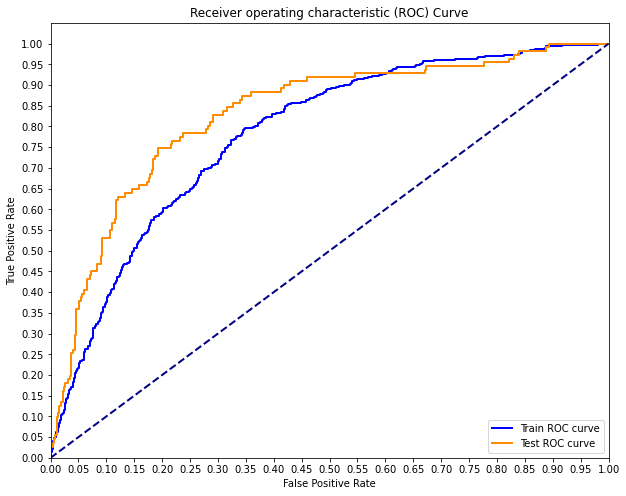

In [19]:
plot_roc(pipeline_lr, X_train, X_test, y_train, y_test)


#### Model Tuning

##### Class Imbalance

Our base model needs improvement regarding predicting 1s. In order to fix this problem, we will address class imbalance. We can use SMOTE or we can use sampling methods. 

In [20]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
# Initiate sampling class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=123)
# Fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
# Summarize class distribution
print(Counter(y_train_over))
print('------------------------------------')
# Fit our model
pipeline_lr.fit(X_train_over, y_train_over)
print('Train Score:', pipeline_lr.score(X_train_over, y_train_over))
print('Test Score:', pipeline_lr.score(X_test, y_test))

Counter({0: 2127, 1: 2127})
------------------------------------
Train Score: 0.7240244475787494
Test Score: 0.7721822541966427


Train Score: 0.7240244475787494
Test Score: 0.7721822541966427
------------------------------------
Training Values 
 0    3080
1    1174
Name: churn, dtype: int64
------------------------------------
Training Accuracy 
 0    0.724024
1    0.275976
Name: churn, dtype: float64



Testing Values:  
 0    644
1    190
Name: churn, dtype: int64
------------------------------------
Testing Accuracy:  
 0    0.772182
1    0.227818
Name: churn, dtype: float64


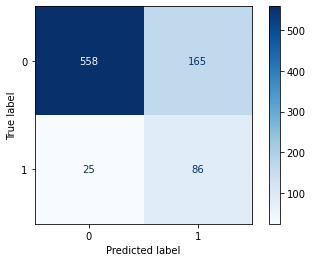

------------------------------------
Testing Accuracy for Decision Tree Classifier: 77.22%
------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.96      0.77      0.85       723
           1       0.34      0.77      0.48       111

    accuracy                           0.77       834
   macro avg       0.65      0.77      0.66       834
weighted avg       0.88      0.77      0.80       834

Train AUC: 0.7876269664282342
Test AUC: 0.8354080221300139
------------------------------------


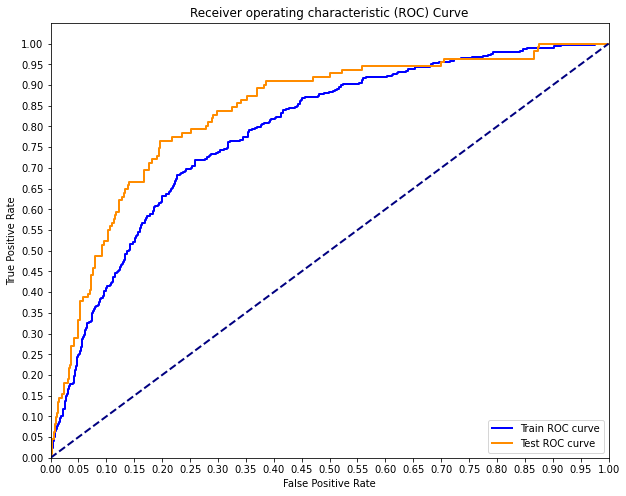

In [21]:
model_control(pipeline_lr, X_train_over, X_test, y_train_over, y_test)

##### SMOTE

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE(sampling_strategy=0.7)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

0    2850
1     483
Name: churn, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

0    2127
1    1488
Name: churn, dtype: int64


In [23]:
lr_smote = LogisticRegression(fit_intercept=False, 
                           C=10e16,  
                           solver='liblinear', 
                           max_iter=10000, 
                           random_state=123) 

lr_smote.fit(X_train_resampled, y_train_resampled)

print('Train Score:', pipeline_lr.score(X_train_resampled, y_train_resampled))
print('Test Score:', pipeline_lr.score(X_test, y_test))

Train Score: 0.5983402489626556
Test Score: 0.8369304556354916


#### Conclusion

***Base Model:***
* Our base model is open for improvement.
* When predicting *0s*, Logistic Regression Model scored high Precision and F1-Score. Unfortunately, only recall made high score when predicting *1s*.

***OverSampling:***
* OverSampling with RandomOverSampler has increased our scores slightly but not good enough to use this model as it is now.

***SMOTE:***
* We used SMOTE to create synthetic data points. Both our train and test scores are very low that we will not investigate further.

### K NEAREST NEIGHBORS

#### Model

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_clf = KNeighborsClassifier(n_neighbors=5)

# Fit the model

knn_clf.fit(X_train_scaled, y_train)

print('Train Score:', knn_clf.score(X_train_scaled, y_train))
print('Test Score:', knn_clf.score(X_test_scaled, y_test))


Train Score: 0.9227691076430572
Test Score: 0.8860911270983214


#### Predictions

In [25]:
model_predictions(knn_clf, X_train_scaled, X_test_scaled, y_train, y_test)

Training Values 
 0    2306
1     193
Name: churn, dtype: int64
------------------------------------
Training Accuracy 
 0    0.922769
1    0.077231
Name: churn, dtype: float64



Testing Values:  
 0    739
1     95
Name: churn, dtype: int64
------------------------------------
Testing Accuracy:  
 0    0.886091
1    0.113909
Name: churn, dtype: float64


#### Confusion Matrix

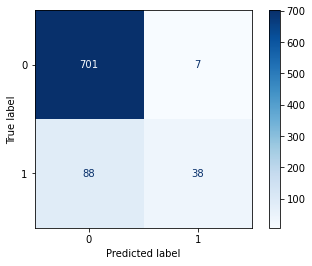

------------------------------------
Testing Accuracy for Decision Tree Classifier: 88.61%
------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       708
           1       0.84      0.30      0.44       126

    accuracy                           0.89       834
   macro avg       0.87      0.65      0.69       834
weighted avg       0.88      0.89      0.86       834



In [26]:
confusion_matrix(knn_clf, X_test_scaled, y_test)

#### ROC Curve

Train AUC: 0.9602206895830228
Test AUC: 0.8528831494933191
------------------------------------


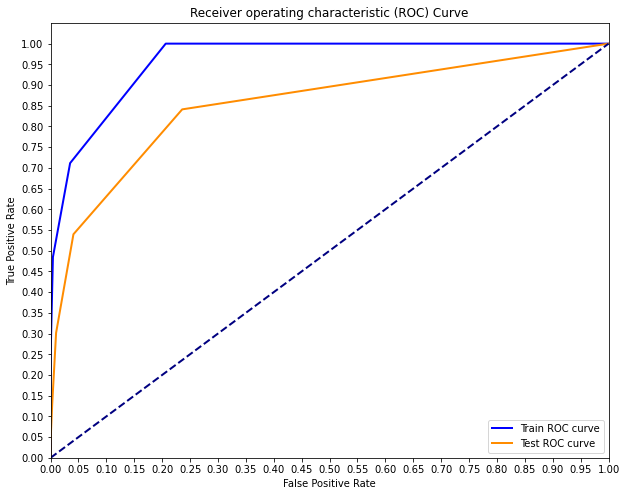

In [27]:
plot_roc_pp(knn_clf, X_train_scaled, X_test_scaled, y_train, y_test)

#### Model Tuning

##### VIF Score

Multicollinearity is a problem when using K Nearest Neighbor as a classifier. Let's check for multicollinearity in our data set using heatmap.

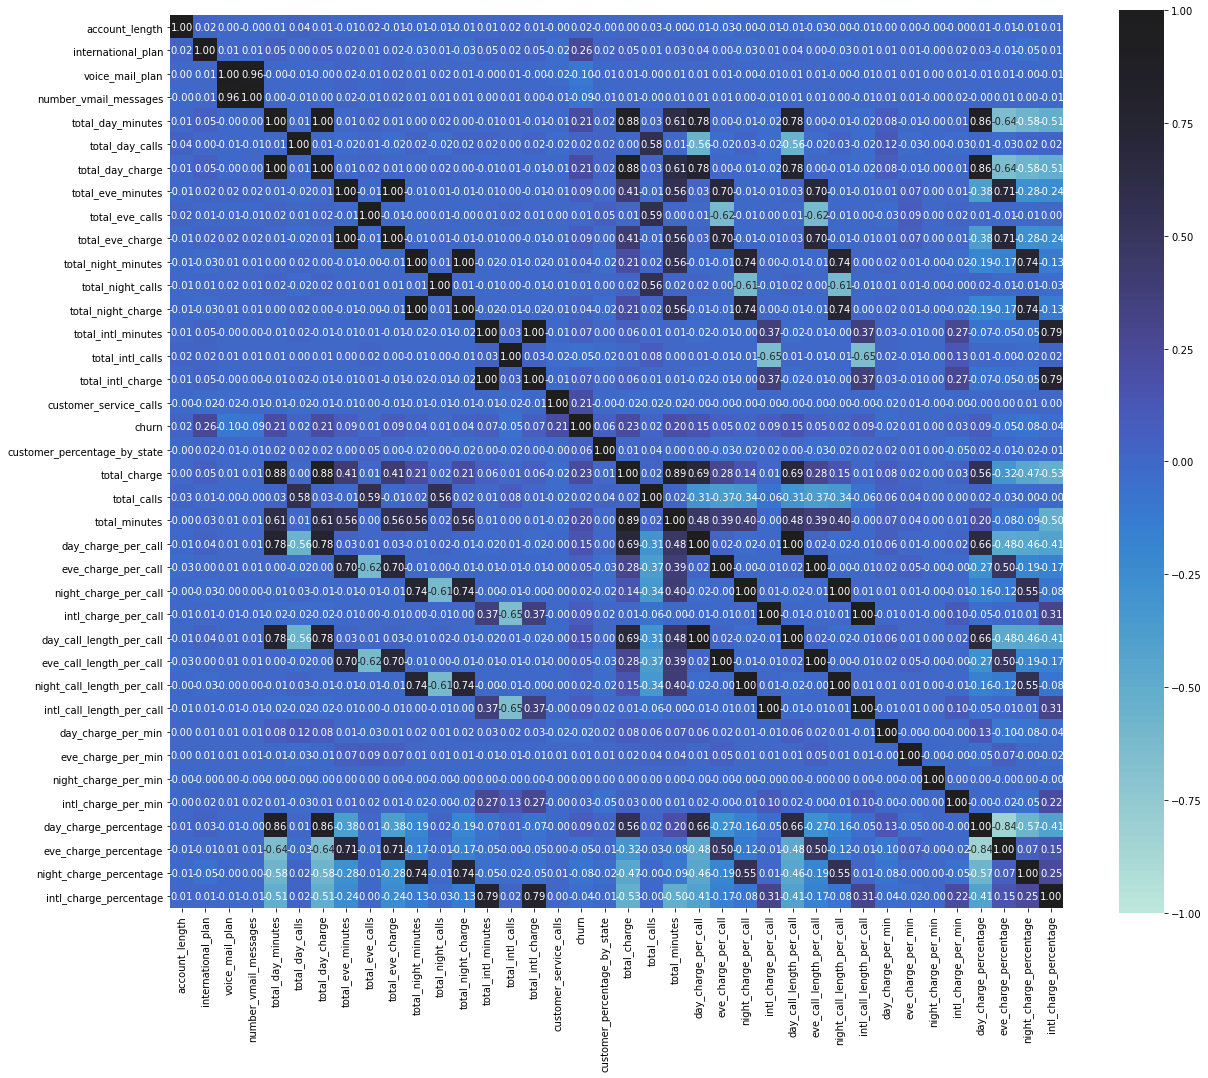

In [28]:
plt.figure(figsize=(20,20))
df_hm = df.drop(['state', 'area_code'], axis=1)

sns.heatmap(df_hm.corr(), 
            vmax=1.0, 
            vmin=-1.0,                 
            square=True, 
            fmt='.2f',
            annot=True, 
            cbar_kws={'shrink': .83}, 
            center = 1.0, 
            yticklabels=df_hm.columns.values, 
            xticklabels=df_hm.columns.values)
plt.show();

As we can see from the heatmap above, there are highly correlated columns as expected. We will eliminate these columns using VIF Score before we feed our data to our K Nearest Neighbor model.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

In [30]:
vif = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif_scores = list(zip(X_train.columns, vif))
vif_scores.sort(key=lambda x: x[1], reverse=True,)
print('VIF SCORES')   
print((vif_scores))
print('------------------------------')
columns_to_use = list()
for vif_score in vif_scores:
    if vif_score[1] < 10:
        columns_to_use.append(vif_score[0])
print('Columns to Use For Logistic Regression','\n', columns_to_use)

VIF SCORES
[('total_day_calls', inf), ('total_eve_calls', inf), ('total_night_calls', inf), ('total_intl_calls', inf), ('total_calls', inf), ('total_day_minutes', 10745765.588249281), ('total_day_charge', 10727703.082981229), ('total_eve_minutes', 2283342.4798204503), ('total_eve_charge', 2260032.6867469056), ('intl_call_length_per_call', 978916.5233951894), ('intl_charge_per_call', 978796.0599585209), ('total_night_minutes', 679370.1724018828), ('total_night_charge', 648423.5483333025), ('total_intl_minutes', 199880.58215252668), ('total_intl_charge', 199590.28628476066), ('day_call_length_per_call', 179628.6817985058), ('day_charge_per_call', 179625.4559836135), ('total_minutes', 97728.93626298508), ('eve_call_length_per_call', 47371.87130016284), ('eve_charge_per_call', 47358.08198634168), ('total_charge', 27255.897185768186), ('night_charge_per_call', 12071.433815048522), ('night_call_length_per_call', 12069.961851523982), ('day_charge_percentage', 6895.430486314906), ('eve_charge_

In [31]:
X_train = X_train[columns_to_use]
X_test = X_test[columns_to_use]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_clf_vif = KNeighborsClassifier(n_neighbors=5)

# Fit the model

knn_clf_vif.fit(X_train_scaled, y_train)

print('Train Score:', knn_clf_vif.score(X_train_scaled, y_train))
print('Test Score:', knn_clf_vif.score(X_test_scaled, y_test))

Train Score: 0.8807523009203682
Test Score: 0.8369304556354916


Train Score: 0.8807523009203682
Test Score: 0.8369304556354916
------------------------------------
Training Values 
 0    2201
1     298
Name: churn, dtype: int64
------------------------------------
Training Accuracy 
 0    0.880752
1    0.119248
Name: churn, dtype: float64



Testing Values:  
 0    698
1    136
Name: churn, dtype: int64
------------------------------------
Testing Accuracy:  
 0    0.83693
1    0.16307
Name: churn, dtype: float64


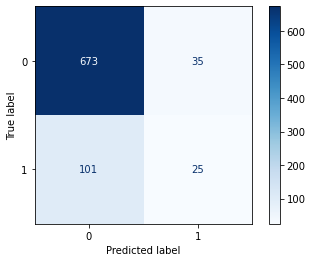

------------------------------------
Testing Accuracy for Decision Tree Classifier: 83.69%
------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       708
           1       0.42      0.20      0.27       126

    accuracy                           0.84       834
   macro avg       0.64      0.57      0.59       834
weighted avg       0.80      0.84      0.81       834

Train AUC: 0.8847133624691706
Test AUC: 0.6676307057662989
------------------------------------


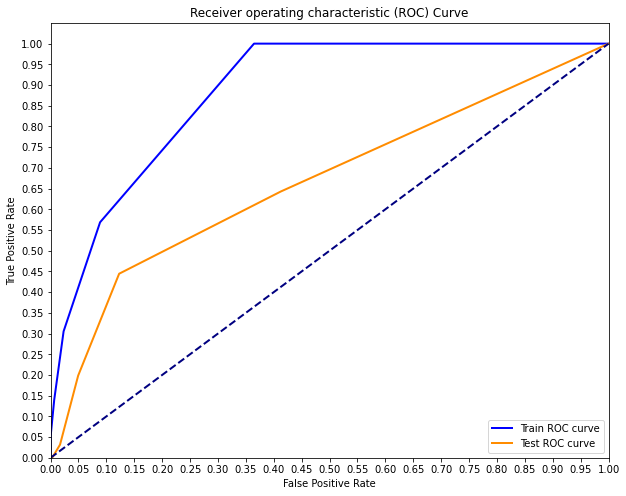

In [32]:
model_control_pp(knn_clf_vif, X_train_scaled, X_test_scaled, y_train, y_test)

##### Best K Value

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        train_score = knn.score(X_train, y_train)
        test_score = knn.score(X_test, y_test)
        if test_score > best_score:
            best_k = k
            best_score = test_score
    
    print("Best Value for k: {}".format(best_k))
    
find_best_k(X_train_scaled, y_train, X_test_scaled, y_test)

Best Value for k: 3


In [35]:
"""
  We will use the best k value given by the find_best_k function above.
"""

knn_3_clf = KNeighborsClassifier(n_neighbors=3)

# Fit the model
knn_3_clf.fit(X_train_scaled, y_train)

print('Train Score:', knn_3_clf.score(X_train_scaled, y_train))
print('Test Score:', knn_3_clf.score(X_test_scaled, y_test))

Train Score: 0.929171668667467
Test Score: 0.8896882494004796


Train Score: 0.929171668667467
Test Score: 0.8896882494004796
------------------------------------
Training Values 
 0    2322
1     177
Name: churn, dtype: int64
------------------------------------
Training Accuracy 
 0    0.929172
1    0.070828
Name: churn, dtype: float64



Testing Values:  
 0    742
1     92
Name: churn, dtype: int64
------------------------------------
Testing Accuracy:  
 0    0.889688
1    0.110312
Name: churn, dtype: float64


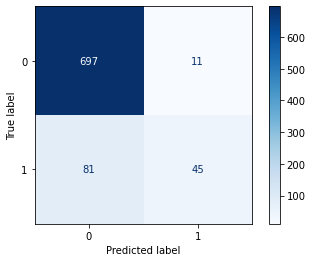

------------------------------------
Testing Accuracy for Decision Tree Classifier: 88.97%
------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       708
           1       0.80      0.36      0.49       126

    accuracy                           0.89       834
   macro avg       0.85      0.67      0.72       834
weighted avg       0.88      0.89      0.87       834

Train AUC: 0.9726518058203673
Test AUC: 0.7923840911129046
------------------------------------


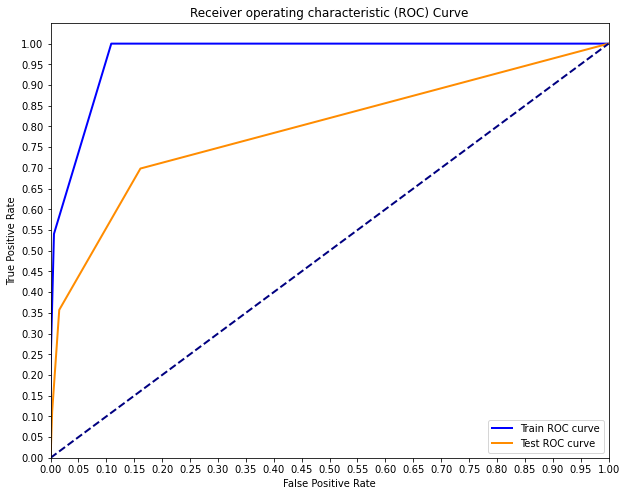

In [36]:
model_control_pp(knn_3_clf, X_train_scaled, X_test_scaled, y_train, y_test)

##### GridSearch

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=23)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_clf_gs = KNeighborsClassifier()

knn_grid = {'n_neighbors': [3, 5, 7, 9],
            'weights':['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan'],
            'n_jobs': [-1]}

knn_gridsearch = GridSearchCV(estimator=knn_clf_gs, 
                              param_grid=knn_grid, 
                              cv=5,
                              return_train_score=True)



# Fit to the data
knn_gridsearch.fit(X_train_scaled, y_train)

# Best parameters for our Decision Tree model:
print('Best parameters for Our KNN Model:')
knn_gridsearch.best_params_

Best parameters for Our KNN Model:


{'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 7, 'weights': 'uniform'}

In [38]:
knn_clf_gs = KNeighborsClassifier(metric='manhattan', 
                                  n_jobs=-1, 
                                  n_neighbors=7, 
                                  weights='uniform')

knn_clf_gs.fit(X_train_scaled, y_train)

print('Train Score:', knn_clf_gs.score(X_train_scaled, y_train))
print('Test Score:', knn_clf_gs.score(X_test_scaled, y_test))

Train Score: 0.9047619047619048
Test Score: 0.8896882494004796


Train Score: 0.9047619047619048
Test Score: 0.8896882494004796
------------------------------------
Training Values 
 0    2261
1     238
Name: churn, dtype: int64
------------------------------------
Training Accuracy 
 0    0.904762
1    0.095238
Name: churn, dtype: float64



Testing Values:  
 0    742
1     92
Name: churn, dtype: int64
------------------------------------
Testing Accuracy:  
 0    0.889688
1    0.110312
Name: churn, dtype: float64


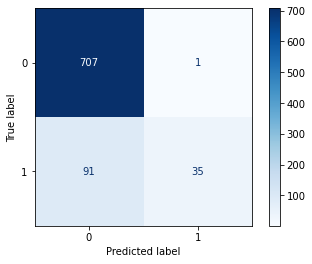

------------------------------------
Testing Accuracy for Decision Tree Classifier: 88.97%
------------------------------------
Classification Matrix:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       708
           1       0.97      0.28      0.43       126

    accuracy                           0.89       834
   macro avg       0.93      0.64      0.69       834
weighted avg       0.90      0.89      0.86       834

Train AUC: 0.9445673694314326
Test AUC: 0.8384674020267241
------------------------------------


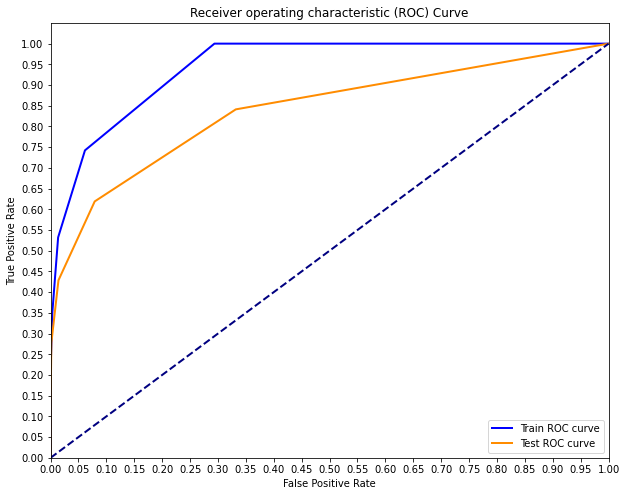

In [39]:
model_control_pp(knn_clf_gs, X_train_scaled, X_test_scaled, y_train, y_test)

#### Conclusion

***Base Model:***
* We initiated KNNClassifier with 5 closest neighbors.
* Our Train and Test Scores are quite high. {Train: 92%, Test: 88%}
* Precision for this binary classification model is high enoug to be accepted. {0: 0.89, 1: 0.84}
* How ever, our F1-Score when predicting *1s* is very low. {0: 0.94, 1: 0.44}
* AUC values seem good. {Train: 0.96, Test: 0.85}

***VIF Score:***
* We selected columns with VIF scores smaller than 10. Columns we used in our column:
           .   day_charge_per_min
           .   intl_charge_per_min
           .   customer_percentage_by_state
           .   total_ininternational_plantl_charge
           .   customer_service_calls
           .   account_length
           .   night_charge_per_min
           .   eve_charge_per_min
* Our Test Scores have not improved, on the contrary there is a great amount decrease.

***Best K Value:***
* Our find_best_function determined determined the best *k = 3*. 
* When we use *k=3* for our model we can see a slight improvement in our F1=Score when predicting *1s*.

***GridSearch:***
* Best parameters for Our KNN Model are {'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 7, 'weights': 'uniform'}
* We can see betterment in our model but out *F1-Score* is still too low to accept.

### DECISION TREES

#### Model


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

"""
    We will use StandardScaler to scale our training data.
    Set random_state to 123 for our Decision Tree model. 
"""


scaler = StandardScaler()
model = DecisionTreeClassifier(random_state=123)                       

pipeline_dt = Pipeline([('ss', scaler), 
                        ('m', model), 
                       ])

# Fit the model

pipeline_dt.fit(X_train, y_train)

print('Train Score:', pipeline_dt.score(X_train, y_train))
print('Test Score:', pipeline_dt.score(X_test, y_test))

Our vanilla model has a very high Test Score(0.94). Let's dig deeper if it is as good predicting both our classes.

In [ ]:
plt.figure(figsize=(12,12), dpi=500, edgecolor='black')

tree.plot_tree(model, 
               feature_names=X.columns,
               class_names=np.unique(y).astype('str'),
               filled=True, rounded=True)
plt.show()

#### Predictions

In [ ]:
model_predictions(pipeline_dt, X_train, X_test, y_train, y_test)

Our model has very low accuracy predicting 1s. As we can see from the decision tree image above, our decision tree is following the path which gives ***class 0*** more weight.

#### Confusion Matrix

In [ ]:
confusion_matrix(pipeline_dt, X_test, y_test)

#### ROC Curve

In [ ]:
plot_roc_pp(pipeline_dt, X_train, X_test, y_train, y_test)

#### Model Tuning

##### Class Imbalance

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initiate sampling class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=123)
# Fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train_scaled, y_train)
# Summarize class distribution
print(Counter(y_train_over))

dt_clf_os = DecisionTreeClassifier(random_state=123)                       

dt_clf_os.fit(X_train_over, y_train_over)

In [ ]:
model_control_pp(dt_clf_os, X_train_over, X_test_scaled, y_train_over, y_test)


As we can see both our ***Precision*** and ***F1-Score*** is improved after dealing with class imbalance.

In [ ]:
plot_feature_importances(dt_clf_os, X_train_scaled)

##### GridSearch

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dt_clf_gs = DecisionTreeClassifier(random_state=123)

dt_grid = {
           'class_weight': ['None', 'balanced'],
           'criterion': ['gini', 'entropy'],
           'max_depth': [2, 3, 4, 5, 6],
           'min_samples_leaf': [1, 2, 3, 4, 5, 6],
           'min_samples_split': [2, 5, 10],
           'random_state': [123]
          }

dt_gridsearch = GridSearchCV(estimator = dt_clf_gs, 
                             param_grid = dt_grid, 
                             cv=5, 
                             return_train_score=True)


# Fit to the data
dt_gridsearch.fit(X_train_scaled, y_train)

# Best parameters for our Decision Tree model:
print('Best parameters for Our Decision Tree Model:')
dt_gridsearch.best_params_

Let's create a decision tree model with the best parameters given by the gridsearch.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dt_clf = DecisionTreeClassifier(class_weight = 'balanced', 
                                criterion = 'entropy',
                                max_depth = 5,
                                min_samples_leaf = 1,
                                min_samples_split = 2, 
                                random_state = 123)
dt_clf.fit(X_train_scaled, y_train)


In [ ]:
model_control_pp(dt_clf, X_train_scaled, X_test_scaled, y_train, y_test)

In [ ]:
plot_feature_importances(dt_clf, X_train_scaled )

#### Conclusion

***Base Model:***
* Our vanilla model for Decision Tree Classifier has 0.97 precision when predicting *0s* and 0.76 precision when predicting *1s*. 
* F1-Score for *class 0* is 0.97, and for *class 1*, it is 0.79.
* Train AUC (0.78) and Test AUC (0.84) can be improved.

***Over Sampling:***
* In order to deal with class imbalance, we used RandomOverSampler and get a training set with equally sized binary classes: {0: 2127, 1: 2127}
* Given that, our precision is increased for minority class: {0: 0.97, 1: 0.80}
* F1-Score is also increased for minority class: {0: 0.97, 1: 0.81}
* Train and Test AUC stayed the same as Vanilla model.
* Top  features:
          1.   total_charge
          2.   customer_service_calls
          3.   international_plan
          4.   total_intl_charge
          5.   number_vmail_messages

***Grid Search:***
* We used GridSearch to find the best parameters for our Decision Tree Classifier.
* While our training score decreased scarcely while the test score increased fairly similarly.
* We almost have perfect precision for both our classes: {0: 0.97, 1: 0.96}
* Our F1-Score is also improved: {0: 0.98, 1: 0.86}
* AUC values for both datasets are decreased. ROC Curve is visually well below to be defined as good.
* Top 5 features:
          1.   total_charge
          2.   international_plan
          3.   customer_service_calls
          4.   number_vmail_messages
          5.   total_intl_charge

### RANDOM FOREST

#### Model

In [ ]:
"""
   - Preform train/test split.
   - Scale data.
   - Initiate random forest classifier.
   - Fit the model.
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf_clf = RandomForestClassifier(criterion='gini', 
                                max_depth= 5, 
                                n_estimators=20, 
                                random_state=123 
                                )

# Fit the model

rf_clf.fit(X_train_scaled, y_train)

print('Train Score:', rf_clf.score(X_train_scaled, y_train))
print('Test Score:', rf_clf.score(X_test_scaled, y_test))


In [ ]:
plot_feature_importances(rf_clf, X_train_scaled)

#### Predictions

In [ ]:
model_predictions(rf_clf, X_train_scaled, X_test_scaled, y_train, y_test)

#### Confusion Matrix

In [ ]:
confusion_matrix(rf_clf, X_test_scaled, y_test)

#### ROC Curve

In [ ]:
"""
       Random Forest Classifier doesn't ha decision_function attribute.
       We will use predict_proba instead.
"""
plot_roc_pp(rf_clf, X_train_scaled, X_test_scaled, y_train, y_test)

#### Model Tuning

##### Class Imbalance 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Initiate sampling class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=123)
# Fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train_scaled, y_train)
# Summarize class distribution
print(Counter(y_train_over))


rf_clf_os = RandomForestClassifier(criterion='gini', 
                                   max_depth= 5, 
                                   n_estimators=20, 
                                   random_state=123 
                                  )

In [ ]:
model_control_pp(rf_clf_os, X_train_over, X_test_scaled, y_train_over, y_test)

In [ ]:
plot_feature_importances(rf_clf_os, X_train_over)

##### Bagged Trees

Let's instantiate a BaggingClassifier. First, initialize DecisionTreeClassifier and set the same parameters that we did above for criterion and max_depth. Also set the n_estimators parameter for our BaggingClassifier to 20.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', 
                                                        max_depth=5, 
                                                        random_state=123), 
                                 n_estimators=20, 
                                 random_state=123)



In [ ]:
bagged_tree.fit(X_train_scaled, y_train)

In [ ]:
model_control_pp(bagged_tree, X_train_scaled, X_test_scaled, y_train, y_test)

#### Conclusion

***Base Model***
* Our base model has high train and test accuracy which is not enough to decide by itself.
* We have high precision when predicting both classes. {0: 0.93, 1: 1.00}
* Unfortunately we have low F1-Score while predicting *1s*. {0: 0.96, 1: 0.69}
* Both our train and test AUC is high enoug to be accepted. 
* Top 5 features:
          1.   total_charge
          2.   customer_service_calls
          3.   total_minutes
          4.   total_day_minutes
          5.   total_day_charge

***Over Sampling:***
* In order to deal with class imbalance, we used RandomOverSampler and get a training set with equally sized binary classes: {0: 2127, 1: 2127}
* Our test score decreased to 0.38 which indicates Over Sampling is not working for model improvement. 
* Given that, our precision decreased for both classes: {0: 0.93, 1: 0.16}
* F1-Score also decreased for minority class: {0: 0.47, 1: 0.27}
* We have close to perfect Train AUC (0.95). Our Test AUC is 0.55 which indicates for a binary class classification, it is no better than guessing.

***Bagged Trees:***
* We initiated bagging classifier with the same parameters that our base model have to compare the results. 
* Our training and test scores are close to perfect score 1.0.
* Precision for predicting for both class is high enough to accept this model. {0: 0.97, 1: 1.0}
* F1-Score for both classes are high enough to accept the model.{0: 0.98, 1: 0.87}
* Our AUC scores are not perfect but again high enough to accept. {0: 0.95, 1: 0.89}


### XGBOOST

#### Model

In [15]:
"""
   - Preform train/test split.
   - Scale data.
   - Initiate random XGBoost classifier.
   - Fit the model.
"""
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_clf = xgb.XGBClassifier(max_depth=5, 
                            learning_rate=0.1, 
                            random_state=123)

# Fit the model

xgb_clf.fit(X_train_scaled, y_train)

print('Train Score:', xgb_clf.score(X_train_scaled, y_train))
print('Test Score:', xgb_clf.score(X_test_scaled, y_test))


Train Score: 0.985594237695078
Test Score: 0.9760191846522782


In [18]:
sorted(xgb_clf.feature_importances_)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.009498646,
 0.0117143225,
 0.011730415,
 0.012396691,
 0.012490555,
 0.01257105,
 0.012680755,
 0.013636415,
 0.014153928,
 0.014230648,
 0.014737106,
 0.014892578,
 0.015149675,
 0.015348709,
 0.015930131,
 0.017220927,
 0.017872721,
 0.01801868,
 0.018730724,
 0.018851927,
 0.01964868,
 0.023133516,
 0.044918314,
 0.054386806,
 0.057733826,
 0.060602393,
 0.07621861,
 0.1641003,
 0.20740093]

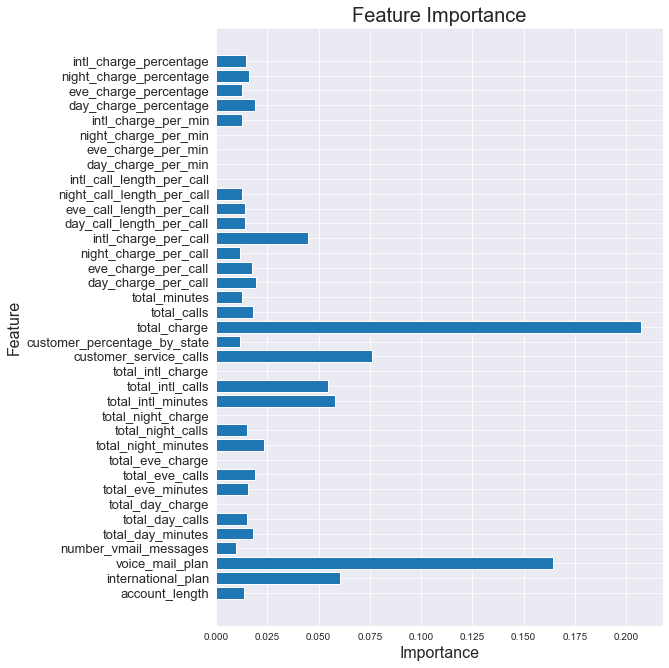

In [16]:
plot_feature_importances(xgb_clf, X, X_train_scaled)

#### Predictions

In [ ]:
model_predictions(xgb_clf, X_train_scaled, X_test_scaled, y_train, y_test)

#### Confusion Matrix

In [ ]:
confusion_matrix(xgb_clf, X_test_scaled, y_test)

#### ROC Curve

In [ ]:
plot_roc_pp(xgb_clf, X_train_scaled, X_test_scaled, y_train, y_test)

#### Model Tuning

##### GridSearch

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_clf_gs = xgb.XGBClassifier(random_state=123)

xgb_grid = {
            'learning_rate': [0.01, 0.1, 0.5], 
            'gamma': [0, 0.01, 0.1], 
            'max_depth': [2, 5, 6, 10], 
            'min_child_weight': [0.1, 1, 10], 
            'subsample': [0.5, 0.7, 0.9], 
            'n_estimators': [5, 10, 20, 100]
           }

xgb_gridsearch = GridSearchCV(estimator=xgb_clf_gs, 
                              param_grid=xgb_grid, 
                              cv=5, 
                              return_train_score=True)

xgb_gridsearch.fit(X_train_scaled, y_train)

print('Best Parameters for Our XGBoost Model:')
xgb_gridsearch.best_params_


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_clf_gs = xgb.XGBClassifier(gamma=0, 
                               learning_rate=0.1, 
                               max_depth=6, 
                               min_child_weight=0.1, 
                               n_estimators=100, 
                               subsample=0.5, 
                               random_state=123)

# Fit the model

xgb_clf_gs.fit(X_train_scaled, y_train)

print('Train Score:', xgb_clf_gs.score(X_train_scaled, y_train))
print('Test Score:', xgb_clf_gs.score(X_test_scaled, y_test))


In [ ]:
plot_feature_importances(xgb_clf_gs, X_train_scaled)

In [ ]:
model_control_pp(xgb_clf_gs, X_train_scaled, X_test_scaled, y_train, y_test)

#### Conclusion

***Base Model:***
* Our base model has high train and test scores. {Train: 98%, Test: 97%}
* Precision is almost perfect when predicting both classes. {0: 0.97, 1: 1.0}
* XGBoost Model has the best F1-Score compared to the rest of models. {0: 0.99, 1: 0.90}
* AUC scores are the highest we have ever reached. {Train: 0.99, Test: 0.93}
* Top 5 features:
          1.   total_charge
          2.   voice_mail_plan
          3.   customer_service_calls
          4.   international_plan
          5.   total_intl_minutes

***GridSearch:***
* We applied GridSearch to find the best parameters for our model and run pur XGBoost classifier model with this parameters.
* There is a slight decrease in train and test scores. {Train: 98%, Test: 97%}
* We have the same precision as our base model. {0: 0.97, 1: 1.0}
* F1-Score is the same as base model. {0: 0.99, 1: 0.90}
* There is a slight decrease in our AUC scores. {Train: 0.98, Test: 0.92}
* Top 5 features:
          1.   total_charge
          2.   voice_mail_plan
          3.   customer_service_calls
          4.   intl_charge_per_call
          5.   international_plan




## SUMMARY

We used 5 Classification Model to create our base models and we tried to improve these models with different tuning methods. 


In light of of test results, ensemble methods predicted our churn data better than Logistic Regression and K Nearest Neighbors models. 

Best model version of ensembe methods:

* Decision Tree Model with GridSearch tuning
* Random Forest Model with Bagged Trees
* XGBoost Model with Base model

The best model to predict our binary classification problem is ***XGBoost Model***. We will use XGBoost model to predict our company's customer churn rate. It has a 97.6% test accuracy.

